In [1]:
import numpy as np
import pandas as pd
import uproot as ur

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf
import energyflow as ef

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()

In [2]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)

# [Omnifold Paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.182001) Background

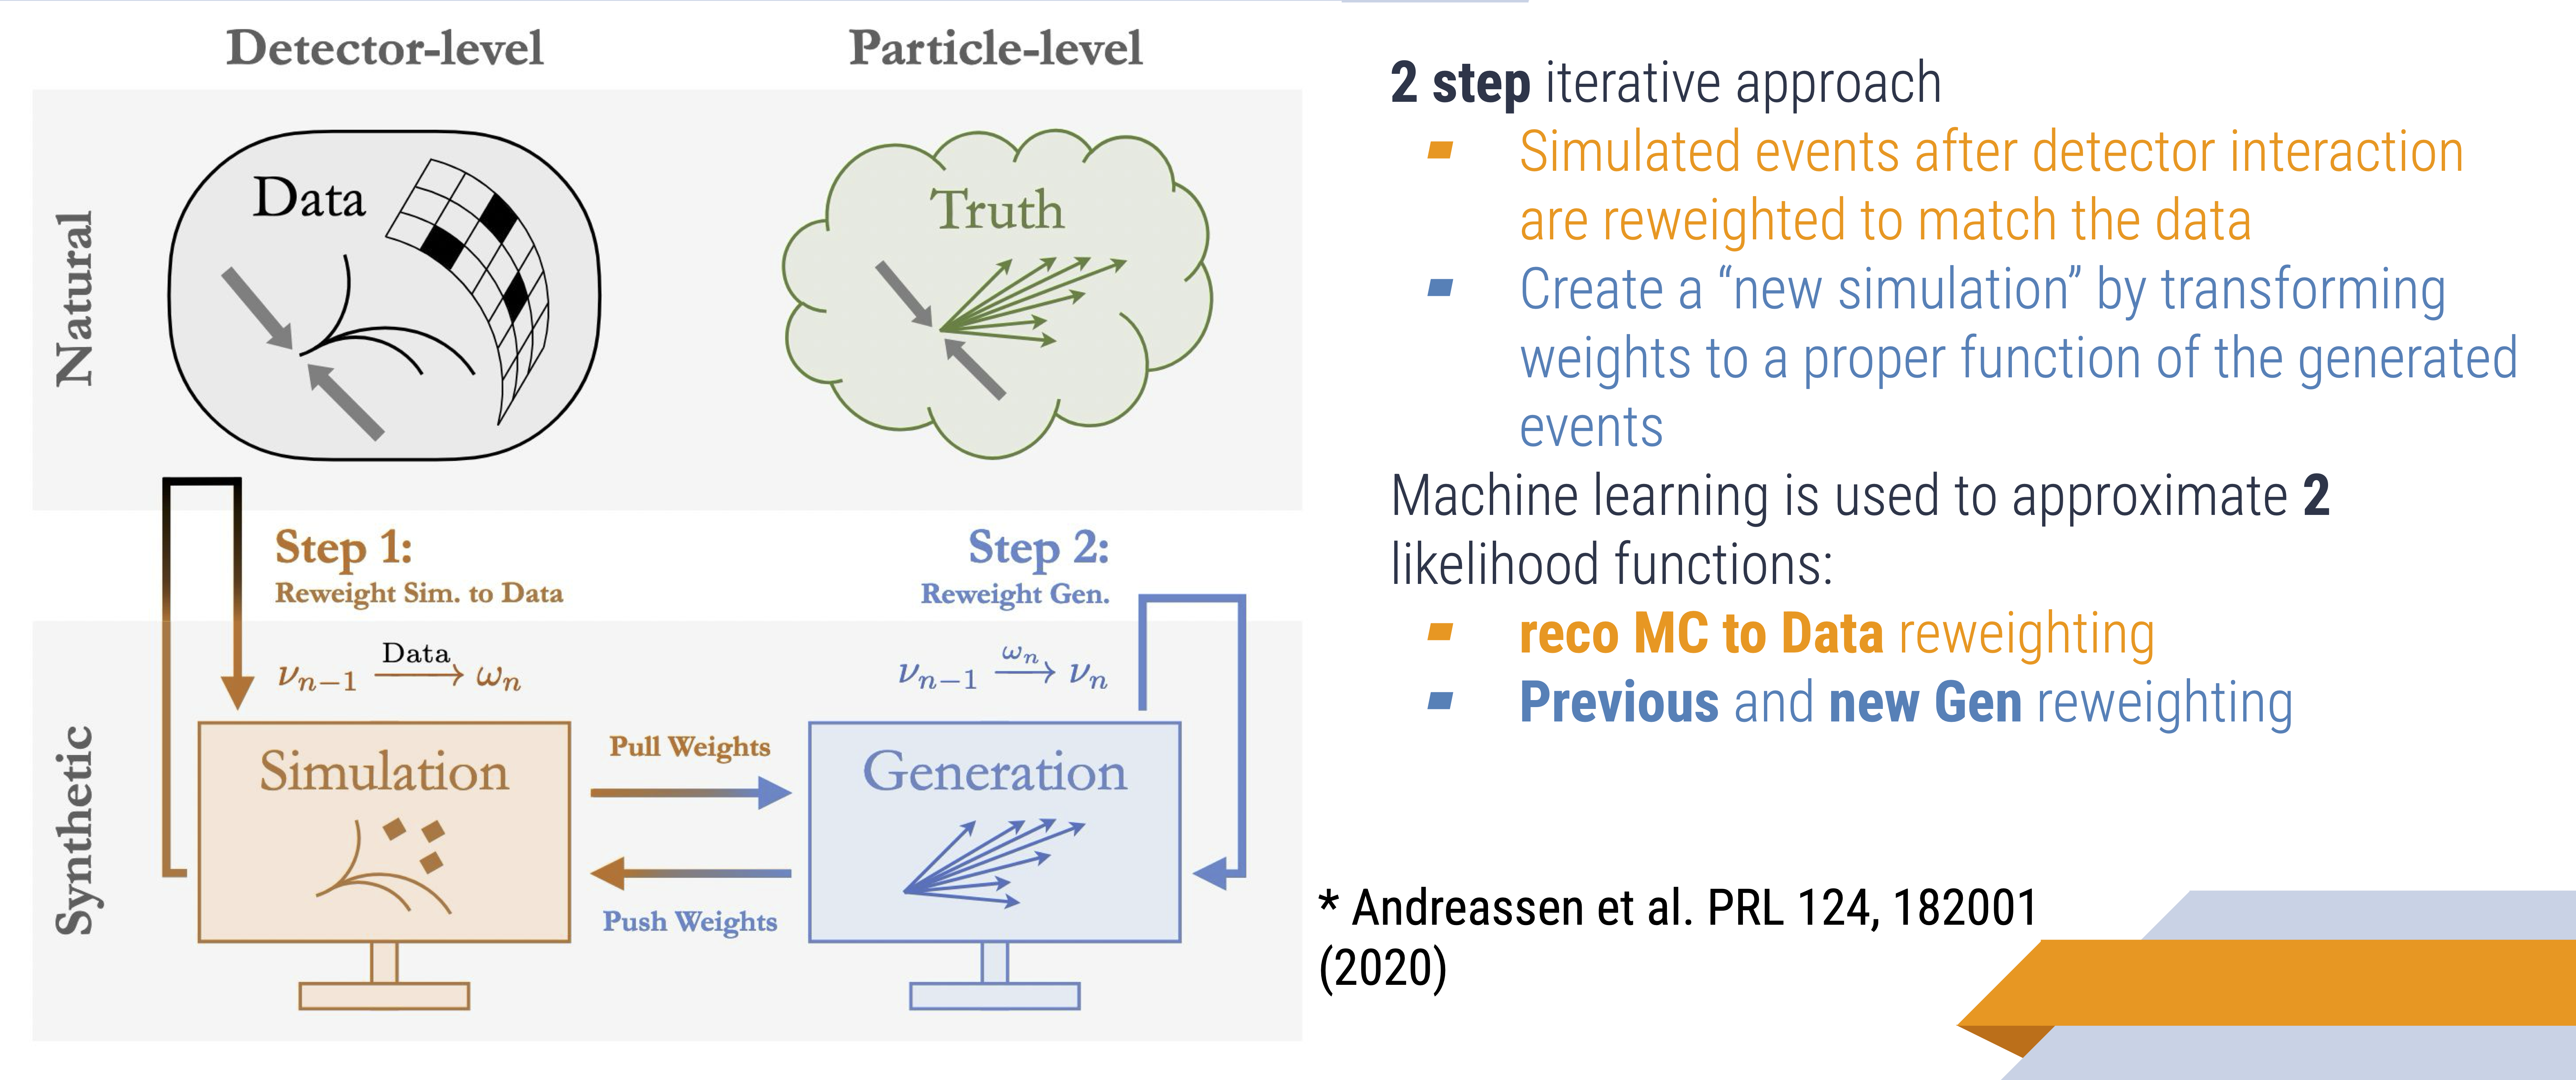

In [3]:
Image(filename='Omnifold_explained.png',width=1500) 

|   |   |   |
|---|---|---|
|Synthetic Generator-Level Sim   | $\theta_{0,G}$  | Truth-Level Sim  |
|Synthetic Reconstruction-Level Sim   | $\theta_{0,S}$   | Full Reco-Level Sim  |
|Natural Reconstruction  | $\theta_\mathrm{unknown,S}$  | Observed Detector Data  |
|Natural Truth   |$\theta_\mathrm{unknown,G}$   | Nature  |


___
___

# OmniFold Example 1: Simple 1D Gaussian [[Original Repo](https://github.com/hep-lbdl/OmniFold)]

In [4]:
N_Events = 10**5

In [5]:

#Synthetic
theta0_G = np.random.normal(0.2,0.8,N_Events)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

#Natural
theta_unknown_G = np.random.normal(0,1, N_Events)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G]) 

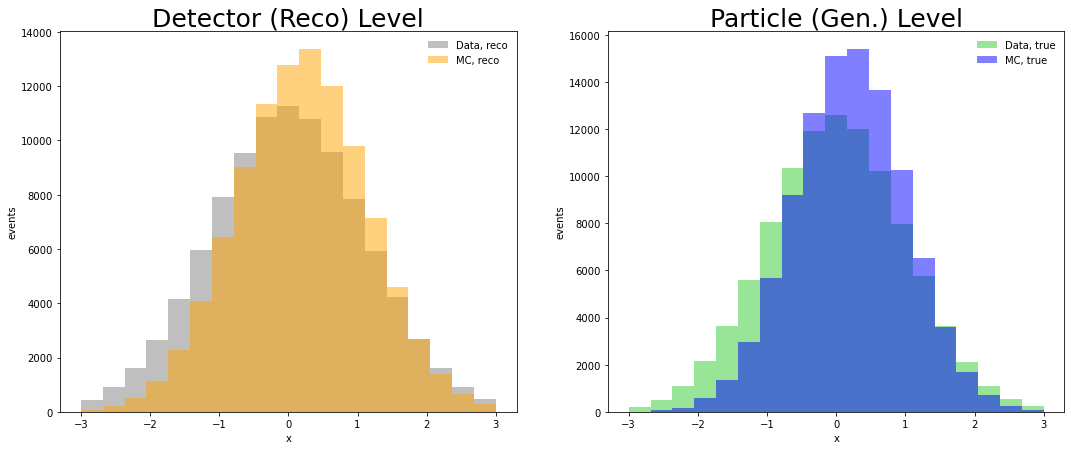

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18,7))


axes[0].set_title("Detector (Reco) Level",fontsize=25)
axes[1].set_title("Particle (Gen.) Level",fontsize=25)

axes[0].hist(theta_unknown_S,bins=np.linspace(-3,3,20),color='black',label="Data, reco",alpha=0.25)
axes[0].hist(theta0_S,bins=np.linspace(-3,3,20),color='orange',label="MC, reco",alpha=0.5)
axes[1].hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='limegreen',alpha=0.5,label="Data, true")
axes[1].hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")


for ax in np.ravel(axes):
    ax.set_xlabel("x")
    ax.set_ylabel("events")
    ax.legend(frameon=False)
    _ = ax.legend(frameon=False)

### Define the Model Architecture - A simple classifier!

In [7]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_gaus = Model(inputs=inputs, outputs=outputs)

### OmniFold

In [8]:
N_Iterations = 3
myweights = of.omnifold(theta0_G, theta0_S, theta_unknown_S, N_Iterations, model_gaus)

2024-06-10 16:23:25.563757: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
print(np.shape(myweights))

(3, 2, 100000)


1.0083203114157915


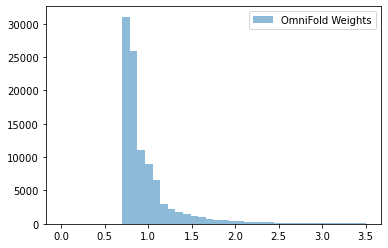

In [10]:
plt.hist(myweights[-1,1,:],label='OmniFold Weights',alpha=0.5,bins=np.linspace(0,3.5,41))
_ = plt.legend()
print(np.mean(myweights[-1,1,:]))

### Plot Omnifold, the weighted $\theta_G$ distribution

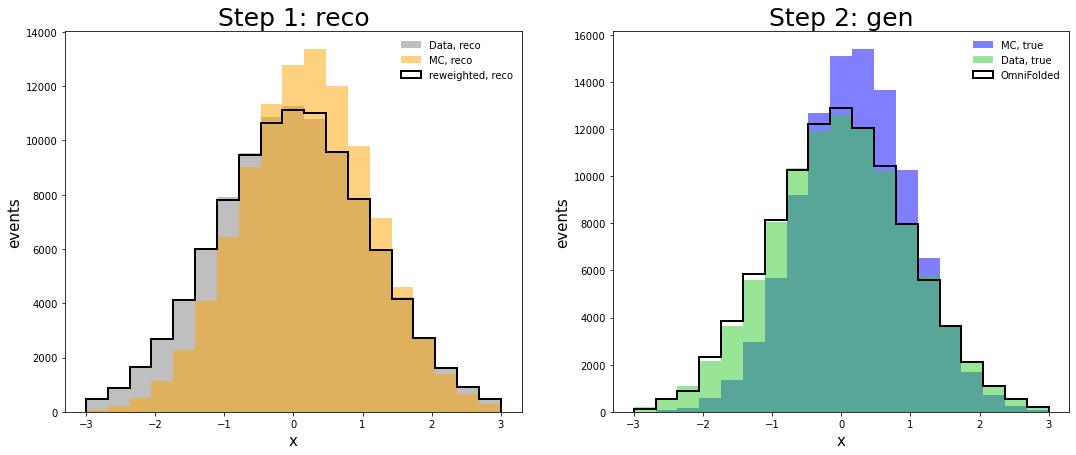

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18,7))

axes[0].hist(theta_unknown_S,bins=np.linspace(-3,3,20),color='black',label="Data, reco",alpha=0.25)
axes[0].hist(theta0_S,bins=np.linspace(-3,3,20),color='orange',label="MC, reco",alpha=0.5)
axes[0].hist(theta0_S,weights=myweights[-1, 0, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="reweighted, reco",lw="2")
axes[0].set_title("Step 1: reco",fontsize=25)

axes[1].hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
axes[1].hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='limegreen',alpha=0.5,label="Data, true")
axes[1].hist(theta0_G,weights=myweights[-1, 1, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw="2")
axes[1].set_title("Step 2: gen", fontsize=25)

for ax in np.ravel(axes):
    ax.set_xlabel("x",fontsize=15)
    ax.set_ylabel("events",fontsize=15)
    ax.legend(frameon=False)
    _ = ax.legend(frameon=False)

### $\rightarrow$ Try increasing iterations. Can play with classifier, but perhaps for more complex distributions

___
___

# Omnifold Example 2: Z+Jet Pythia and Herwig w/ Delphes

`gen` is particle level simulation, and `sim` is detector level simulation

We (arbitrarily) choose Pythia to be our simulation, and `Herwig` to be our "data"

In [12]:
N_Events = 10**4

In [ ]:
pythia = ef.zjets_delphes.load('Pythia26', num_data=N_Events,cache_dir="./") # our sythetic sim
herwig = ef.zjets_delphes.load('Herwig', num_data=N_Events,cache_dir="./")   # our 'data' sim

In [ ]:
print(list(pythia.keys()))
print(np.shape(pythia['gen_jets']),"\n")

print(list(herwig.keys()))
print(np.shape(herwig['sim_jets']),"\n")

- `jets` - The jet axis four vector, as ($p_\mathrm{Tjet}$, $y_\mathrm{jet}$, $\phi_\mathrm{jet}$, $m_\mathrm{jet}$)

- `particles` - The rescaled jet constituents ($p_\mathrm{T}$/100,$y−y_\mathrm{jet}$,$\phi−\phi_\mathrm{jet}$, fPID)

- `mults` - The constituent multiplicity of the jet.
- `lhas` - The Les Houches (β=1/2) angularity.
- `widths` - The jet width (β=1 angularity).
- `ang2s` - The β=2 angularity (note that this is very similar to the jet mass, but does not depend on particle masses).
- `tau2s` - The 2-subjettiness with β=1.
- `sdms` - The groomed mass with Soft Drop parameters zcut=0.1 and β=0.
- `zgs` - The groomed momentum fraction (same Soft Drop parameters as above).

### In theory, we can unfold all of the observables above _simultaneously_, but let's start with just 6!
$p_\mathrm{Tjet}$, $y_\mathrm{jet}$, $\phi_\mathrm{jet}$, $m_\mathrm{jet}$, $m_\mathrm{zg,jet}$, Mult$_\mathrm{jet}$

In [ ]:
# sim
theta0_S = np.column_stack((pythia['sim_jets'], pythia['sim_zgs'], pythia['sim_mults']))
theta0_G = np.column_stack((pythia['gen_jets'], pythia['gen_zgs'], pythia['gen_mults']))


# 'data'
theta_unknown_S = np.column_stack((herwig['sim_jets'], herwig['sim_zgs'], herwig['sim_mults']))
theta_unknown_G = np.column_stack((herwig['gen_jets'], herwig['gen_zgs'], herwig['gen_mults']))

In [ ]:
print(np.shape(theta_unknown_G))

## Plot the distributions before Unfolding

In [ ]:
binning = [ #simple plotting bins
np.linspace(0, 800,  81),   #jet pT
np.linspace(-4, 4, 81),     #jet y
np.linspace(0.0, 6.2, 63),  #jet phi
np.linspace(0, 80,  81),    #jet mass
np.linspace(0, 0.5, 51),    # groomed mass
np.linspace(0, 80, 81)]     # multiplicity

labels = [
    "$p_\mathrm{Tjet}$",
    "y_\mathrm{jet}$",
    "\phi_\mathrm{jet}$",
    "m_\mathrm{jet}$",
    "m_\mathrm{groomed}$",
    "Mult_\mathrm{jet}"]
    

N = len(binning)

fig, axes = plt.subplots(2, 3, figsize=(15,7))

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(theta0_S[:,i],binning[i],histtype="step",color='black',ls=':',label="MC, reco")
    _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='limegreen',alpha=0.5,label="Data, true")
    _,_,_=ax.hist(theta_unknown_S[:,i],binning[i],color='black',label="Data, reco",alpha=0.25)

    ax.set_title(labels[i],fontsize=25)
    #ax.set_xlabel(labels[i])
    #ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
fig.tight_layout()

In [ ]:
inputs = Input(np.shape(theta0_G)[-1], )
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [ ]:
N_Iterations = 5

myweights = of.omnifold(theta0_G,theta0_S,theta_unknown_S,N_Iterations,model_dis)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,7))

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='orange',alpha=0.5,label="Data, true")
    _,_,_=ax.hist(theta0_G[:,i],weights=myweights[-1, 1, :],bins=binning[i],color='black',histtype="step",label="OmniFolded",lw="2")

    #ax.set_title(labels[i])
    #ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
fig.tight_layout()

___
___

# OmniFold: DIY

### 1. Add Jet Features, or or add iterations to the unfolding
careful adding both: might take a while!

hint: append theta0 and theta_unkwonw. myweights = of.omnifold(theta0_G,theta0_S,theta_unknown_S,N_Iterations,model_dis)

### 2. Unfold particle observables: $p_\mathrm{T}$/100,$y−y_\mathrm{jet}$,$\phi−\phi_\mathrm{jet}$, fPID

In [ ]:
N_Events = 10**5 #important for particle excersize

hint: unfolded distributions are just weighted histograms

### 3. What observables can you make with unfolded particles?